# Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc



# load the dataset

In [33]:
# Load the dataset
filepath = "C:/Users/WA/New folder/BINF5507-Assignment1/BINF5507-Assignment2/data/heart_disease_uci.csv"
df = pd.read_csv(filepath)

# Display first few rows
df.head()
df.describe()

,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


#  data preprocessing 

In [ ]:

#
df['sex'] = df['sex'].str.lower().map({'male': 1, 'female': 0}).astype(float)
# slope preprocessing
# Encode 'slope': upsloping → 1, flat → 2, downsloping → 3
df['slope'] = df['slope'].map({'upsloping': 1, 'flat': 2, 'downsloping': 3}).astype(float)
 #Encode 'exang' (exercise-induced angina): Yes → 1, No → 0
df['exang'] = df['exang'].map({True: 1, False: 0}).astype(float)

# Encode 'thal': Normal → 3, Fixed Defect → 6, Reversible Defect → 7
df['thal'] = df['thal'].map({'normal': 3,'fixed defect': 6,'reversable defect': 7}).astype(float)

# Encode 'cp' (chest pain type): 
df['cp'] = df['cp'].map({'typical angina' : 1,'atypical angina' : 2,'non-anginal pain': 3, 'asymptomatic': 4}).astype(float)

# Encode 'restecg': False → 0, True → 1
df['restecg'] = df['restecg'].map({False: 0, True: 1}).astype(float)
# Encode 'fbs': False → 0, True → 1
df['fbs'] = df['fbs'].map({False: 0, True: 1}).astype(float)

# Process the target "num" column.
df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1).astype(float)
# remove the unneeded categorical data 
df = df.drop(columns=['dataset'])

# Display the first few rows of the final DataFrame
print(df.head())


   age  sex   cp  trestbps   chol  fbs  restecg  thalch  exang  oldpeak  \
0   63  1.0  1.0     145.0  233.0  1.0      NaN   150.0    0.0      2.3   
1   67  1.0  4.0     160.0  286.0  0.0      NaN   108.0    1.0      1.5   
2   67  1.0  4.0     120.0  229.0  0.0      NaN   129.0    1.0      2.6   
3   37  1.0  NaN     130.0  250.0  0.0      NaN   187.0    0.0      3.5   
4   41  0.0  2.0     130.0  204.0  0.0      NaN   172.0    0.0      1.4   

   slope   ca  thal  num  
0    3.0  0.0   6.0  0.0  
1    2.0  3.0   3.0  1.0  
2    2.0  2.0   7.0  1.0  
3    3.0  0.0   3.0  0.0  
4    1.0  0.0   3.0  0.0  


# remove duplicates and columns with more than 60% missing values

In [ ]:
# remove duplicates
df = df.drop_duplicates().reset_index(drop=True)
# Check missing values

missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)
# Set the threshold for missing values (60%)
threshold = 0.6  

# Find columns where the percentage of missing values is greater than 60%
cols_to_drop = df.columns[df.isnull().mean() > threshold]

# Drop those columns
df = df.drop(columns=cols_to_drop)

# Print removed columns
print(f"Removed columns: {list(cols_to_drop)}")
# remove the NANs as the linear regression model didn't work with any Nan
df = df.dropna()


df.describe()


age           0.000000
sex           0.000000
cp           22.137405
trestbps      6.434024
chol          3.162486
fbs           9.814613
restecg     100.000000
thalch        5.997819
exang         5.997819
oldpeak       6.761178
slope        33.478735
ca           66.303162
thal         52.671756
num           0.000000
dtype: float64
Removed columns: ['restecg', 'ca']


,age,sex,cp,trestbps,chol,fbs,thalch,exang,oldpeak,slope,thal,num
count,917.000000,917.000000,714.000000,858.00000,888.000000,827.000000,862.000000,862.000000,855.000000,610.000000,434.000000,917.000000
mean,53.503817,0.789531,3.322129,132.13986,199.122748,0.165659,137.539443,0.388631,0.881287,1.770492,5.087558,0.552890
std,9.435326,0.407864,1.044528,19.07454,110.902751,0.371999,25.951446,0.487722,1.092234,0.619694,1.919075,0.497466
min,28.000000,0.000000,1.000000,0.00000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,3.000000,0.000000
25%,47.000000,1.000000,2.000000,120.00000,175.000000,0.000000,120.000000,0.000000,0.000000,1.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.00000,223.000000,0.000000,140.000000,0.000000,0.500000,2.000000,6.000000,1.000000
75%,60.000000,1.000000,4.000000,140.00000,268.000000,0.000000,157.000000,1.000000,1.500000,2.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.00000,603.000000,1.000000,202.000000,1.000000,6.200000,3.000000,7.000000,1.000000


In [ ]:

x = df.drop(columns=['chol'])   # Independent and object variables
y = df['chol']  # Dependent variable (target)
print(X_train.isnull().sum())  # Check for NaN values
print(np.isinf(X_train).sum())  # Check for infinite values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( x , y, test_size=0.2, random_state=42)


# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred_lr = lr_model.predict(X_test)










age         0
sex         0
cp          0
trestbps    0
fbs         0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
num         0
dtype: int64
age         0
sex         0
cp          0
trestbps    0
fbs         0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
num         0
dtype: int64


# Evaluate the model

In [ ]:


r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr)

print(f"Linear Regression R² Score: {r2_lr:.4f}")  # Higher is better (max = 1)
print(f"Linear Regression RMSE: {rmse_lr:.4f}")  # Lower is better



Linear Regression R² Score: 0.1620
Linear Regression RMSE: 9903.8167


# # ElasticNet Regression Model

In [ ]:


# Define the parameter grid: adjust these ranges as appropriate for your dataset
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Initialize an ElasticNet model
elastic = ElasticNet(max_iter=10000)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=elastic,
                           param_grid=param_grid,
                           cv=5,               # 5-fold cross-validation
                           scoring='r2',       # Using R² score to evaluate performance
                           n_jobs=-1)          # Use all available cores

# Fit grid search to your training data
grid_search.fit(X_train, y_train)

# Display the best parameters and best cross-validated R² score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation R² score:", grid_search.best_score_)

# Use the best model from grid search for predictions
best_model = grid_search.best_estimator_
y_pred_en = best_model.predict(X_test)

# Evaluate on the test set
r2_en = r2_score(y_test, y_pred_en)
rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))

print(f"ElasticNet Test R² Score: {r2_en:.4f}")
print(f"ElasticNet Test RMSE: {rmse_en:.4f}")


Best parameters found: {'alpha': 0.1, 'l1_ratio': 0.7}
Best cross-validation R² score: 0.06105011788977888
ElasticNet Test R² Score: 0.1627
ElasticNet Test RMSE: 99.4765


# Heatmap of R2 and RMSE


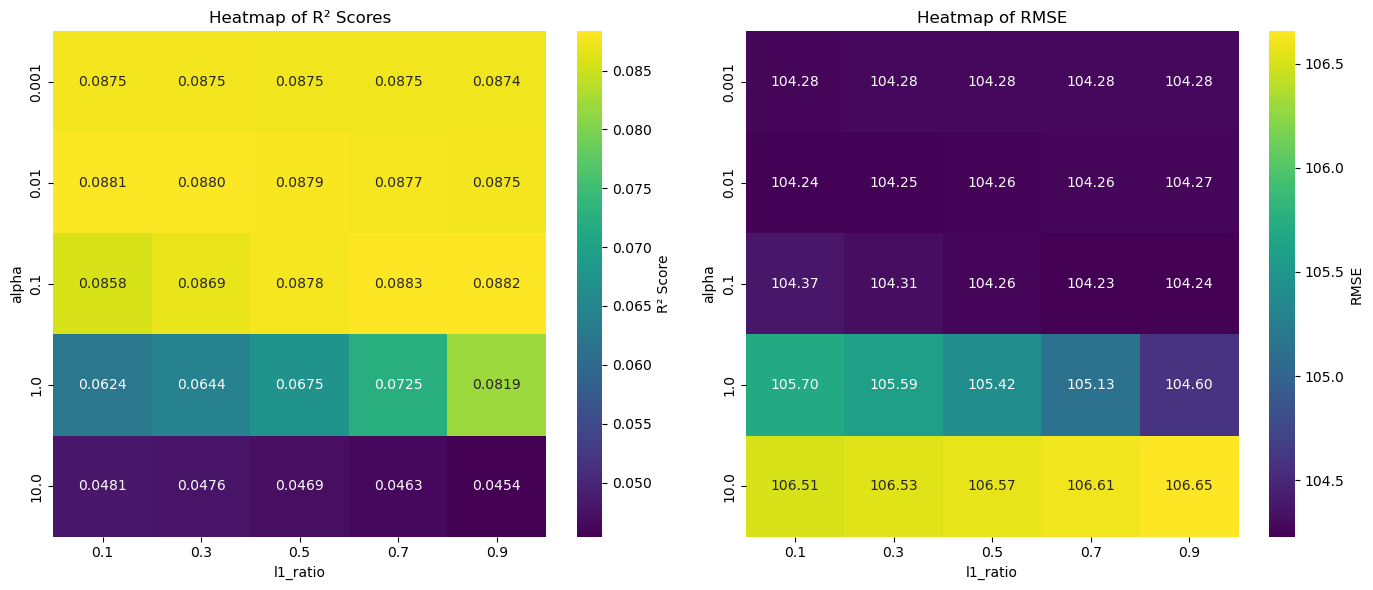

In [ ]:


# Define the parameter grid
alphas = [0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

# Prepare a list to store the results
results = []

# Set up a cross-validation strategy (5-fold CV)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over all combinations of alpha and l1_ratio
for alpha in alphas:
    for l1_ratio in l1_ratios:
        # Initialize the ElasticNet model with current parameters
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42)
        
        # Use cross_val_predict to generate cross-validated predictions on X_train
        y_pred = cross_val_predict(model, X_train, y_train, cv=cv)
        
        # Calculate the R² score and RMSE on the training set predictions
        r2 = r2_score(y_train, y_pred)
        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        
        # Store the results
        results.append({
            'alpha': alpha,
            'l1_ratio': l1_ratio,
            'R2': r2,
            'RMSE': rmse
        })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Pivot the results DataFrame to get matrices for heatmaps
pivot_r2 = results_df.pivot(index='alpha', columns='l1_ratio', values='R2')
pivot_rmse = results_df.pivot(index='alpha', columns='l1_ratio', values='RMSE')

# Create the heatmaps
plt.figure(figsize=(14, 6))

# Heatmap for R² scores
plt.subplot(1, 2, 1)
sns.heatmap(pivot_r2, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'R² Score'})
plt.title("Heatmap of R² Scores")
plt.xlabel("l1_ratio")
plt.ylabel("alpha")

# Heatmap for RMSE values
plt.subplot(1, 2, 2)
sns.heatmap(pivot_rmse, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'RMSE'})
plt.title("Heatmap of RMSE")
plt.xlabel("l1_ratio")
plt.ylabel("alpha")

plt.tight_layout()
plt.show()


# Best model based on R²

In [27]:
# results_df is the DataFrame with R2 scores for each combination
best_r2 = results_df['R2'].max()
best_model_info = results_df[results_df['R2'] == best_r2]
print("Best model based on R²:\n", best_model_info)


Best model based on R²:
     alpha  l1_ratio        R2       RMSE
13    0.1       0.7  0.088328  104.22933


# Classification Models

In [ ]:

### 3. Classification Models
# Logistic Regression (Hyperparameter tuning)
y_classification = (df["num"] > 0).astype(int)  # Convert num to binary target

# Split data into training and testing sets
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(x , y_classification, test_size=0.2, random_state=42)
# Initialize logistic regression
logreg = LogisticRegression(max_iter=5000)
# param_grid = {"penalty": ["l1", "l2"], "solver": ["liblinear", "saga"]}


param_grid = [
    {"penalty": ["l1"], "solver": ["liblinear", "saga"]},  # l1 works with liblinear & saga
    {"penalty": ["l2"], "solver": ["liblinear", "saga", "lbfgs", "sag", "newton-cg"]},  # l2 works with more solvers
]



#Perform grid search
logreg_cv = GridSearchCV(logreg, param_grid, scoring="accuracy", cv=5)
logreg_cv.fit(X_train_clf, y_train_clf)
# Best parameters and score
best_logreg = logreg_cv.best_estimator_
y_pred_log = best_logreg.predict(X_test_clf)

print("Best Parameters:", logreg_cv.best_params_)
print("Best Score:", logreg_cv.best_score_)




Best Parameters: {'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 1.0


# k-NN Classifier

In [ ]:

test_neighbors = [1, 5, 10]
knn_scores = {}

for n in test_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_clf, y_train_clf)
    y_pred_knn = knn.predict(X_test_clf)
    
    acc = accuracy_score(y_test_clf, y_pred_knn)
    f1 = f1_score(y_test_clf, y_pred_knn, average='weighted')  # Use 'macro' or 'micro' as needed
    
    knn_scores[n] = {'accuracy': acc, 'f1_score': f1}  # Store both accuracy and F1 score

# Find the best k based on F1-score
best_k = max(knn_scores, key=lambda k: knn_scores[k]['f1_score'])

print(f"Best k-NN model based on F1-score: k={best_k}, F1-score={knn_scores[best_k]['f1_score']:.2f}")


Best k-NN model based on F1-score: k=10, F1-score=0.68


# Evaluation Metrics and Visualization

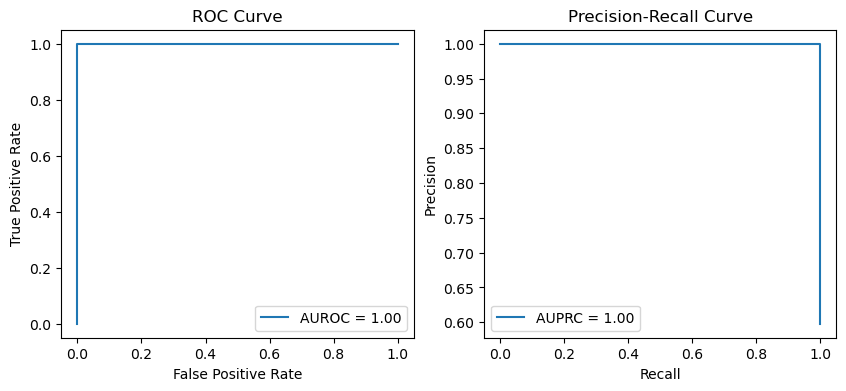

In [31]:
### 4. Evaluation Metrics and Visualization
# Compute AUROC & AUPRC for Logistic Regression
log_probs = best_logreg.predict_proba(X_test_clf)[:, 1]
fpr, tpr, _ = roc_curve(y_test_clf, log_probs)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test_clf, log_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 4))

# AUROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUROC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# AUPRC Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUPRC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.show()